The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


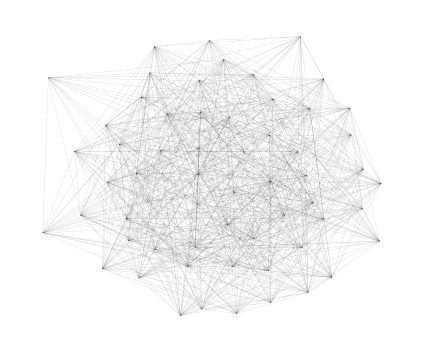

In [51]:
%load_ext autoreload
%autoreload 2
from rbnbr.problems.max_cut import MaxCutProblem
from rbnbr.problems.read_mc import read_mc

%config InlineBackend.figure_format = 'svg'






problem60 = read_mc('./problems/bq/g05_60.0.mc', solution_value=536, keep_prob=1)

problem60.display(save_pgf='./img/g05_60.0.pgf', use_title=False, show_node_labels=False, vis_opts={'node_size': 0, 'edge_alpha': 0.5});


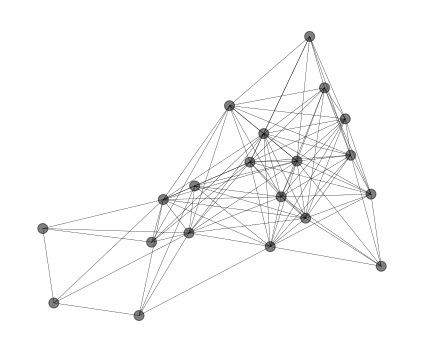

In [52]:
n_v = 20
p = 0.33
problem_rnd = MaxCutProblem.generate_random_maxcut_problem(n_v, r=0.5, weighted=False, solve=True, method='geometric')
problem_rnd.display(save_pgf=f'./img/g{n_v}_{p}.pgf', use_title=False, show_node_labels=False, 
                    vis_opts={'node_size': 100, 'edge_alpha': 1}, edge_width=0.3, reset_pos=True);

In [53]:
problem = problem_rnd

In [54]:
from rbnbr.solver.quantum.qrr import QRRMaxCutSolver
qrr_solver = QRRMaxCutSolver()
qrr_solution = qrr_solver.solve(problem)

qrr_solution.approx_ratio

0.90625

In [55]:
print(qrr_solution)


Solution: 11011100110111100000 
Solution Value: 58.0 
Approximation Ratio: 0.90625


# Test the branch and bound method 

In [56]:
from rbnbr.solver.quantum import QRR_BnB_MC, QRR_BnB_MC_V2
from itertools import product
from tqdm.notebook import tqdm


In [57]:
import cvxpy as cp
import networkx as nx
import numpy as np

def get_bound(graph):
    
    n = graph.number_of_nodes()
    
    u = cp.Variable(n)
    t = cp.Variable()  # This will represent our bound
    
    L = nx.laplacian_matrix(problem.graph).toarray()
    M = (n/4) * (L + cp.diag(u)) + cp.diag(u)

    constraints = [
        cp.sum(u) == 0,
        M << t * np.eye(n)
    ]
    
    prob = cp.Problem(cp.Minimize(t), constraints)

    prob.solve()
    
    u_opt = u.value
    M_opt = (n/4) * (L + np.diag(u_opt))
    
    # Compute largest eigenvector
    evals = np.linalg.eigvals(M_opt)
    return np.max(evals)


In [58]:
print(get_bound(problem.graph))
print(problem.ref_cost)

66.88955155185629
64.0


In [126]:

bnb_solutions = {}
X_type = 'relaxation'
branching_strategy = 'r2'
search_style = 'bfs'

bnb_solver = QRR_BnB_MC(
    bf_threshold=10,
    branching_strategy=branching_strategy, 
    X_type=X_type, 
    topk=5,    
    search_style=search_style,
    optimize_correction=False
)


bnb_solution = bnb_solver.solve(problem)
bnb_solutions[(X_type, branching_strategy)] = bnb_solution

In [127]:
bnb_solution._breadcrumbs[-1]

{'solution': [0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0],
 'cost': 64.0,
 'time': 0.0,
 'approx_ratio': 1.0}

In [100]:
for key, value in bnb_solutions.items():
    print(key)
    print('\t', '\t'.join(str(value).split('\n')))

('relaxation', 'r2')
	 Solution: 01111100110100100001 	Solution Value: 62.0 	Approximation Ratio: 0.96875


In [9]:

from rbnbr.problems.read_mc import MCProblemRetriever

In [10]:
problem_library = MCProblemRetriever()
problem = problem_library.get_random_problem(max_V=100, prefix='g')

g05_60.1


In [11]:
problem_library.available_problems(max_V=100, prefix='g')

['g05_60.0',
 'g05_60.1',
 'g05_60.2',
 'g05_60.3',
 'g05_60.4',
 'g05_60.5',
 'g05_60.6',
 'g05_60.7',
 'g05_60.8',
 'g05_60.9',
 'g05_80.0',
 'g05_80.1',
 'g05_80.2',
 'g05_80.3',
 'g05_80.4',
 'g05_80.5',
 'g05_80.6',
 'g05_80.7',
 'g05_80.8',
 'g05_80.9',
 'g05_100.0',
 'g05_100.1',
 'g05_100.2',
 'g05_100.3',
 'g05_100.4',
 'g05_100.5',
 'g05_100.6',
 'g05_100.7',
 'g05_100.8',
 'g05_100.9']

# 0, Test the QRR first
## Obeservation
it is not true that the high-quality eigenvectors emerge in the leading eigenvectors

In [12]:
from rbnbr.problems.problem_base import ProblemSet
problem_set = ProblemSet()

failed_problems = []

for problem_name in problem_library.available_problems(max_V=100, prefix='g'):
    problem = problem_library.get_problem(problem_name)
    problem_set.add_problem(problem)
    
    print(f'running {problem_name}')

    try:
        # QRR as a baseline
        qrr_solver0 = QRRMaxCutSolver()
        qrr_solution0 = qrr_solver0.solve(problem)
        X_type = qrr_solution0.data['qrr_information'][2]
        problem.add_solution(f'qrr_{X_type}', qrr_solution0)
            
    except Exception as e:
        print(f'error running {problem_name}: {e}')
        failed_problems.append(problem_name)

running g05_60.0
running g05_60.1
running g05_60.2
running g05_60.3
running g05_60.4
running g05_60.5
running g05_60.6
running g05_60.7
running g05_60.8
running g05_60.9
running g05_80.0
running g05_80.1
running g05_80.2
running g05_80.3
running g05_80.4
running g05_80.5
running g05_80.6
running g05_80.7
running g05_80.8
running g05_80.9
running g05_100.0
running g05_100.1
running g05_100.2
running g05_100.3
running g05_100.4
running g05_100.5
running g05_100.6
running g05_100.7
running g05_100.8
running g05_100.9


In [13]:
# for problem in problem_set:
#     print(problem.name)
#     print(problem.solutions('qrr_corr').qrr_cache)


# 1. Test All problems, all X_type, and all Branching Strategies

In [14]:
from rbnbr.problems.problem_base import ProblemSet


failed_problems = {
    # algorithm : [ <failed problem name> ] 
}

problem_set = ProblemSet()
selected_problems = problem_library.available_problems(max_V=100, prefix='g')
for problem_name in selected_problems:
    problem = problem_library.get_problem(problem_name)
    problem_set.add_problem(problem)



In [15]:

# X_types = 'relaxation'
# branching_strategy = 'r2'
# method_name = f'bnb_{X_type}_{branching_strategy}_implied_k'
# failed_problems[method_name] = []

# for problem in tqdm(problem_set, total=len(problem_set)):
#     problem_name = problem.name

#     print(f'running {problem_name}')

#     try:
#         # BNB 
#         bnb_solver = Edge_QBB_MC(X_type=X_type, branching_strategy=branching_strategy)
#         # should be bnb_solution = bnb_solver.solve(problem, qrr_information=qrr_solution.qrr_information)
#         bnb_solution = bnb_solver.solve(problem)
        
#         problem.add_solution(method_name, bnb_solution)
            
#     except Exception as e:
#         print(f'error running {problem_name}: {e} with options {X_type} {branching_strategy}')
#         failed_problems[method_name].append(problem_name)
        


In [16]:
# method_name = f'qrr'
# failed_problems[method_name] = []

# for problem in tqdm(problem_set, total=len(problem_set)):
#     problem_name = problem.name

#     print(f'running QRR {problem_name}')

#     try:
#         # BNB 
#         solver = QRRMaxCutSolver()
#         # should be bnb_solution = bnb_solver.solve(problem, qrr_information=qrr_solution.qrr_information)
#         solution = solver.solve(problem)
        
#         problem.add_solution(f'QRR', solution)
            
#     except Exception as e:
#         print(f'error running {problem_name}: {e}')
#         failed_problems[method_name].append(problem_name)

In [17]:
# X_types = 'relaxation'
# branching_strategy = 'r2'
# method_name = f'bnb_{X_type}_{branching_strategy}_k=20'
# failed_problems[method_name] = []

# pbar = tqdm(problem_set, total=len(problem_set))
# for problem in pbar:
#     problem_name = problem.name

#     pbar.set_description(f'RUNNING {problem_name}')

#     try:
#         # BNB 
#         bnb_solver = Edge_QBB_MC(X_type=X_type, branching_strategy=branching_strategy, topk=20)
#         # should be bnb_solution = bnb_solver.solve(problem, qrr_information=qrr_solution.qrr_information)
#         bnb_solution = bnb_solver.solve(problem)
        
#         problem.add_solution(method_name, bnb_solution)
            
#     except Exception as e:
#         print(f'error running {problem_name}: {e} with options {X_type} {branching_strategy}')
#         failed_problems[method_name].append(problem_name)

In [18]:
# X_types = 'relaxation'
# branching_strategy = 'r2'
# method_name = f'bnb_{X_type}_{branching_strategy}_implied_k_dfs'
# failed_problems[method_name] = []

# pbar = tqdm(problem_set, total=len(problem_set))
# for problem in pbar:
#     problem_name = problem.name

#     pbar.set_description(f'RUNNING {problem_name}')

#     try:
#         # BNB 
#         bnb_solver = Edge_QBB_MC(X_type=X_type, branching_strategy=branching_strategy, search_style='dfs')
#         # should be bnb_solution = bnb_solver.solve(problem, qrr_information=qrr_solution.qrr_information)
#         bnb_solution = bnb_solver.solve(problem)
        
#         problem.add_solution(method_name, bnb_solution)
            
#     except Exception as e:
#         print(f'error running {problem_name}: {e} with options {X_type} {branching_strategy}')
#         failed_problems[method_name].append(problem_name)

In [19]:
# X_types = 'relaxation'
# branching_strategy = 'r2'
# method_name = f'bnb_{X_type}_{branching_strategy}_implied_k_bfs_random_pass'
# failed_problems[method_name] = []

# pbar = tqdm(problem_set, total=len(problem_set))
# for problem in pbar:
#     problem_name = problem.name

#     pbar.set_description(f'RUNNING {problem_name}')

#     try:
#         # BNB 
#         bnb_solver = Edge_QBB_MC(X_type=X_type, random_pass=True, search_style='bfs', branching_strategy=branching_strategy)
#         # should be bnb_solution = bnb_solver.solve(problem, qrr_information=qrr_solution.qrr_information)
#         bnb_solution = bnb_solver.solve(problem)
        
#         problem.add_solution(method_name, bnb_solution)
            
#     except Exception as e:
#         print(f'error running {problem_name}: {e} with options {X_type} {branching_strategy}')
#         failed_problems[method_name].append(problem_name)

In [20]:
# X_types = 'relaxation'
# branching_strategy = 'r2'
# method_name = f'bnb_{X_type}_{branching_strategy}_implied_k_bfs_gap=8'
# failed_problems[method_name] = []

# pbar = tqdm(problem_set, total=len(problem_set))
# for problem in pbar:
#     problem_name = problem.name

#     pbar.set_description(f'RUNNING {problem_name}')

#     try:
#         # BNB 
#         bnb_solver = Edge_QBB_MC(X_type=X_type,  
#                                  search_style='bfs', 
#                                  random_pass=False,
#                                  branching_strategy=branching_strategy, 
#                                  gap=8)
#         # should be bnb_solution = bnb_solver.solve(problem, qrr_information=qrr_solution.qrr_information)
#         bnb_solution = bnb_solver.solve(problem)
        
#         problem.add_solution(method_name, bnb_solution)
            
#     except Exception as e:
#         print(f'error running {problem_name}: {e} with options {X_type} {branching_strategy}')
#         failed_problems[method_name].append(problem_name)

In [21]:

X_type = 'relaxation'
approx_style = 'default'
branching_strategy = 'r2'
gap = 0
random_pass = 0
bound_with_solver = False

real = 'real_' if not bound_with_solver else ''
rp = '_strict' if random_pass == 0 else f'_rp={random_pass}'
aps = '_low-rank' if approx_style == 'low-rank' else ''
method_name = f'{real}bnb_{X_type}_{branching_strategy}_implied_k_bfs_gap={gap}{aps}{rp}'
failed_problems[method_name] = []

pbar = tqdm(problem_set, total=len(problem_set))
for problem in pbar:
    problem_name = problem.name

    pbar.set_description(f'RUNNING {problem_name}')

    try:
        # BNB 
        bnb_solver = Edge_QBB_MC(X_type=X_type,  
                                 search_style='bfs', 
                                 random_pass=random_pass,
                                 branching_strategy=branching_strategy, 
                                 approx_style=approx_style,
                                 gap=gap)
        # should be bnb_solution = bnb_solver.solve(problem, qrr_information=qrr_solution.qrr_information)
        bnb_solution = bnb_solver.solve(problem)
        
        problem.add_solution(method_name, bnb_solution)
            
    except Exception as e:
        print(f'error running {problem_name}: {e} with options {X_type} {branching_strategy}')
        failed_problems[method_name].append(problem_name)

  0%|          | 0/30 [00:00<?, ?it/s]

In [25]:
problem_set.method_performance(method_name)
# Save the performance data to a CSV file
print(method_name)
performance_data = problem_set.method_performance(method_name)
performance_data.to_csv(f'{method_name}.csv', index=False)


real_bnb_relaxation_r2_implied_k_bfs_gap=0_strict


In [26]:
problem_set.method_performance(method_name)

,problem_name,cost,approx_ratio,n_steps
0,g05_60.0,516.0,0.962687,6
1,g05_60.1,515.0,0.968045,5
2,g05_60.2,492.0,0.930057,4
3,g05_60.3,519.0,0.964684,4
4,g05_60.4,485.0,0.920304,2
5,g05_60.5,498.0,0.934334,3
6,g05_60.6,521.0,0.981168,4
7,g05_60.7,516.0,0.964486,4
8,g05_60.8,498.0,0.939623,3
9,g05_60.9,495.0,0.928705,5


In [24]:
test_data = problem_set[0].solutions('bnb_relaxation_r2_implied_k').data

KeyError: 'bnb_relaxation_r2_implied_k'

In [32]:
problem_set[0].solutions('bnb_relaxation_r2_implied_k').data

{'cost': 473.0,
 'solution': array([ 1, -1,  1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1, -1, -1, -1,  1,
         1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1,  1, -1,
        -1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1,
        -1,  1,  1, -1,  1,  1, -1, -1, -1]),
 'time': 0.0,
 'approx_ratio': 0.8824626865671642}

In [33]:
test_data['Problem Name'] = problem_set[2].name

In [49]:
problem_set.method_performance('bnb_relaxation_r2_implied_k_bfs_random_pass')

,problem_name,cost,approx_ratio
0,g05_60.0,473.0,0.882463
1,g05_60.1,480.0,0.902256
2,g05_60.2,463.0,0.875236
3,g05_60.3,466.0,0.866171
4,g05_60.4,485.0,0.920304
5,g05_60.5,474.0,0.889306
6,g05_60.6,483.0,0.909605
7,g05_60.7,492.0,0.919626
8,g05_60.8,481.0,0.907547
9,g05_60.9,475.0,0.891182


In [35]:
problem_set.method_performance('bnb_relaxation_r2_implied_k')

,problem_name,cost,approx_ratio
0,g05_60.0,473.0,0.882463
1,g05_60.1,480.0,0.902256
2,g05_60.2,463.0,0.875236
3,g05_60.3,466.0,0.866171
4,g05_60.4,485.0,0.920304
5,g05_60.5,474.0,0.889306
6,g05_60.6,483.0,0.909605
7,g05_60.7,492.0,0.919626
8,g05_60.8,481.0,0.907547
9,g05_60.9,475.0,0.891182


In [36]:
problem_set.method_performance('QRR')

,problem_name,cost,approx_ratio
0,g05_60.0,465.0,0.867537
1,g05_60.1,467.0,0.877820
2,g05_60.2,463.0,0.875236
3,g05_60.3,466.0,0.866171
4,g05_60.4,485.0,0.920304
5,g05_60.5,474.0,0.889306
6,g05_60.6,483.0,0.909605
7,g05_60.7,492.0,0.919626
8,g05_60.8,481.0,0.907547
9,g05_60.9,475.0,0.891182


In [38]:
problem_set.method_performance('bnb_relaxation_r2_k=20')

,problem_name,cost,approx_ratio
0,g05_60.0,474.0,0.884328
1,g05_60.1,477.0,0.896617
2,g05_60.2,463.0,0.875236
3,g05_60.3,481.0,0.894052
4,g05_60.4,485.0,0.920304
5,g05_60.5,490.0,0.919325
6,g05_60.6,483.0,0.909605
7,g05_60.7,492.0,0.919626
8,g05_60.8,491.0,0.926415
9,g05_60.9,475.0,0.891182


In [40]:
problem_set.method_performance('bnb_relaxation_r2_implied_k_dfs')

,problem_name,cost,approx_ratio
0,g05_60.0,473.0,0.882463
1,g05_60.1,480.0,0.902256
2,g05_60.2,463.0,0.875236
3,g05_60.3,466.0,0.866171
4,g05_60.4,485.0,0.920304
5,g05_60.5,474.0,0.889306
6,g05_60.6,483.0,0.909605
7,g05_60.7,492.0,0.919626
8,g05_60.8,481.0,0.907547
9,g05_60.9,475.0,0.891182


In [ ]:
import pandas as pd
pd.concat([test_data, None])

,Solution Type,Cut Value,Approximation Ratio,Number of Steps,Problem Name
1,bnb_relaxation_r2,474.0,0.884328,3,g05_60.2
0,bnb_relaxation_r3,465.0,0.867537,2,g05_60.2


In [118]:
final_data = None
for idx in range(len(problem_set)):
    problem_name = problem_set[idx].name
    run_data = problem_set[idx].solution_summary()
    if run_data is None:
        continue
    run_data['Problem Name'] = problem_name
    
    final_data = pd.concat([final_data, run_data])


In [119]:
final_data.groupby('Solution Type')['Number of Steps'].mean()

Solution Type
bnb_relaxation_r2    2.8
bnb_relaxation_r3    2.4
Name: Number of Steps, dtype: float64

In [120]:
final_data.groupby('Solution Type')['Approximation Ratio'].mean()

Solution Type
bnb_relaxation_r2    0.913552
bnb_relaxation_r3    0.902334
Name: Approximation Ratio, dtype: float64

In [26]:
# from rbnbr.solver.rqaoa import RQAOAMaxCutSolver
# method_name = 'rqaoa'

# pbar = tqdm(problem_set, total=len(problem_set))
# for problem in pbar:
#     problem_name = problem.name

#     pbar.set_description(f'RUNNING {problem_name}')

#     try:
#         # BNB 
#         rqaoa_solver = RQAOAMaxCutSolver()
#         rqaoa_solution = rqaoa_solver.solve(problem)
        
#         problem.add_solution(method_name, rqaoa_solution)
            
#     except Exception as e:
#         print(f'error running {problem_name}: {e}')
#         failed_problems[method_name].append(problem_name)


  0%|          | 0/30 [00:00<?, ?it/s]

Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
Note: The follow

In [28]:
import pandas as pd
rqaoa_performance = pd.read_csv('./RUN_DATA/rqaoa_performance.csv')
bnb_performance = problem_set.method_performance(method_name)

merged_performance = pd.merge(rqaoa_performance, bnb_performance, on='problem_name', suffixes=('_rqaoa', '_bnb'))


In [29]:
merged_performance['better_bnb'] = merged_performance['approx_ratio_rqaoa'] - merged_performance['approx_ratio_bnb']

In [30]:
(merged_performance['better_bnb'].values < 0).sum()

22

In [38]:
import random 
for i in range(1000000):
    assert random.random() > 0.1

AssertionError: 

True
